In [1]:
import numpy as np, pandas as pd
from sklearn.datasets import fetch_california_housing

%load_ext autoreload
%autoreload 2

df = fetch_california_housing(as_frame=True).data
df['NumPoliceStations'] = np.random.poisson(size=df.shape[0])
df['NumHospitals'] = np.random.poisson(lam=2, size=df.shape[0])
df['AvgDeaths'] = np.random.gamma(shape=2, scale=2, size=df.shape[0])
df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,NumPoliceStations,NumHospitals,AvgDeaths
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,1,2,7.272101
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1,2,4.851810
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,0,2,0.605712


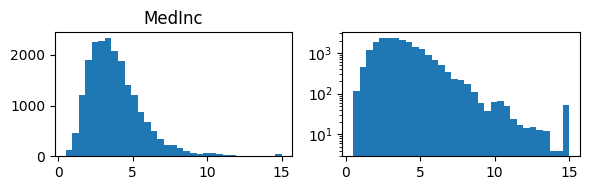

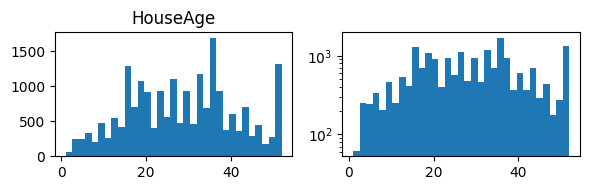

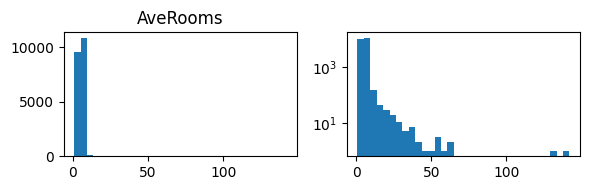

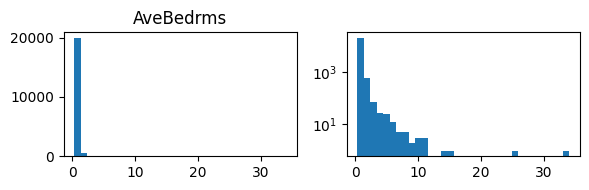

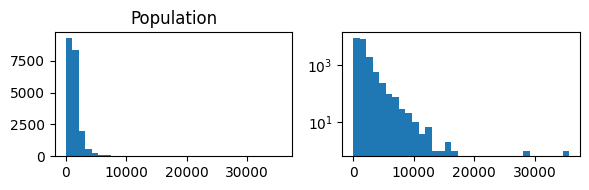

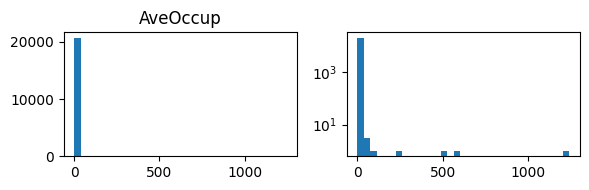

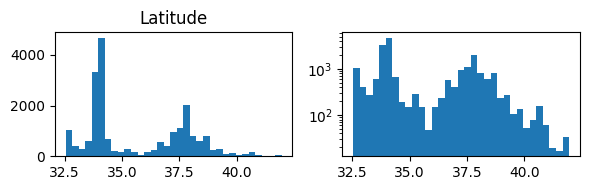

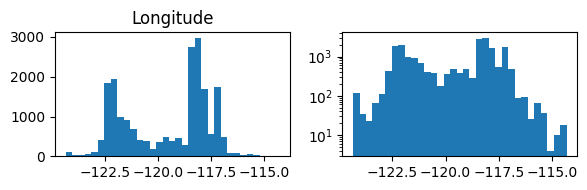

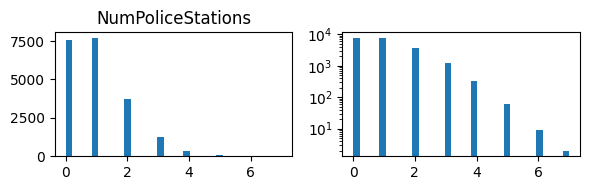

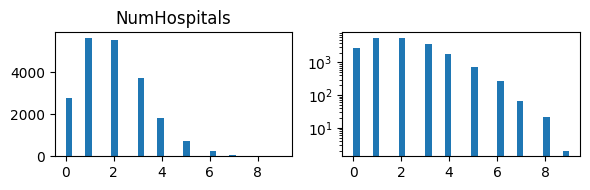

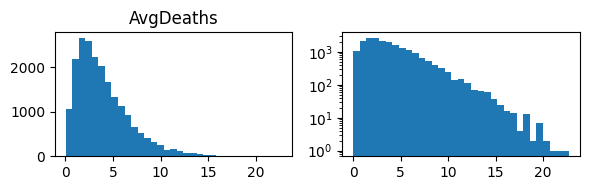

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_df_cols(df, transform_func=None, cols=None):
    '''
    transform_func: callable or dict:
    {
    col_1: func_1,
    col_2: func_2
    }
    '''
    if cols is None:
        cols = df.columns
        
    additional_plot = int(transform_func is not None)
    for col in cols:
        fig, ax = plt.subplots(1, 2 + 2 * additional_plot, figsize=(6 + 6 * additional_plot, 2))
        ax[0].hist(df[col], bins=33)
        ax[1].hist(df[col], bins=33)
        if callable(transform_func):
            ax[2].hist(transform_func(df[col].values), bins=33, color='red')
            ax[3].hist(transform_func(df[col].values), bins=33, color='red')
            ax[3].set_yscale('log')
        elif isinstance(transform_func, dict) and col in transform_func:
            ax[2].hist(transform_func[col](df[col].values), bins=33, color='red')
            ax[3].hist(transform_func[col](df[col].values), bins=33, color='red')
            ax[3].set_yscale('log')
        ax[0].set_title(col)
        ax[1].set_yscale('log')
        fig.tight_layout()
        plt.show()

plot_df_cols(df)

# Часть 1. Однородные пространства через трансформацию признаков

## sklearn.preprocessing

Не меняют форму распределения (только нормализация):
- StandardScaler
- MinMaxScaler
- MaxAbsScaler
- RobustScaler

Меняют:
- np.log
- x ** a
- ax / (x + b)
- PowerTransformer
- QuantileTransformer

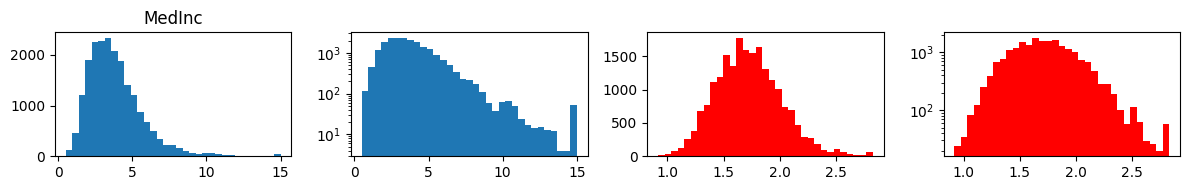

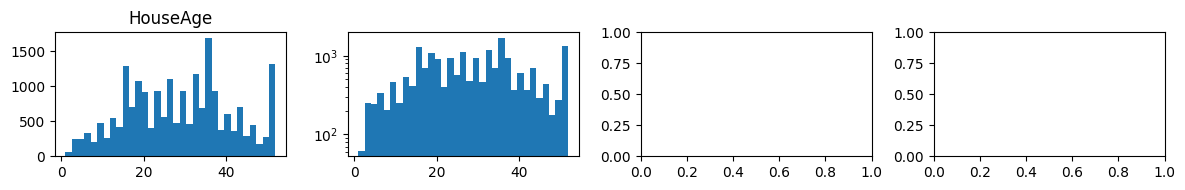

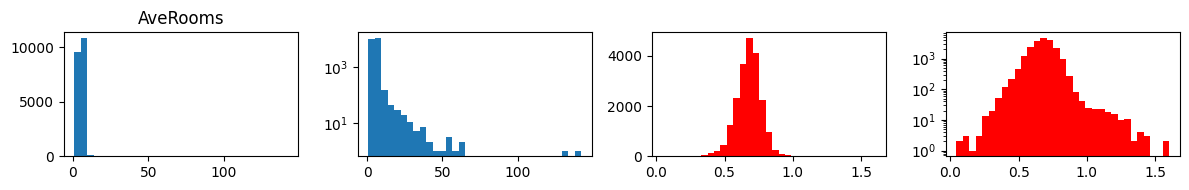

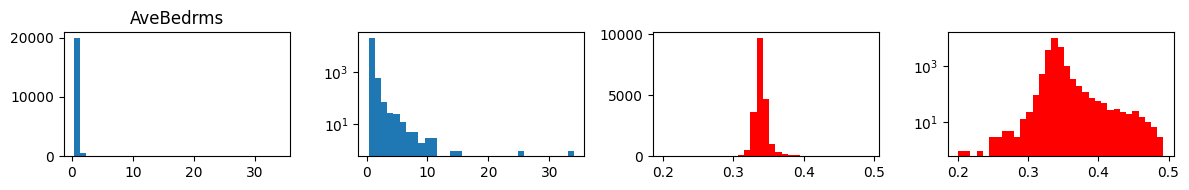

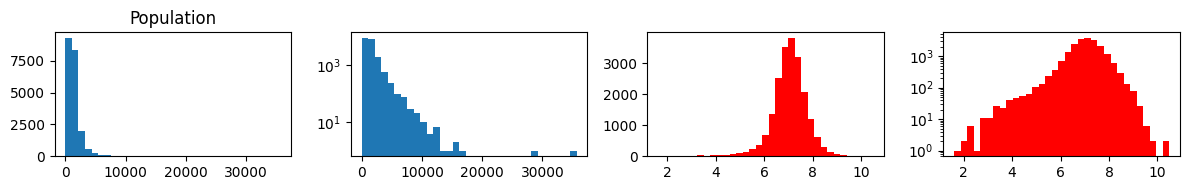

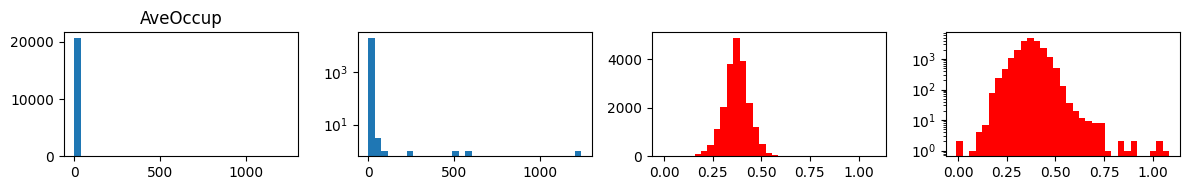

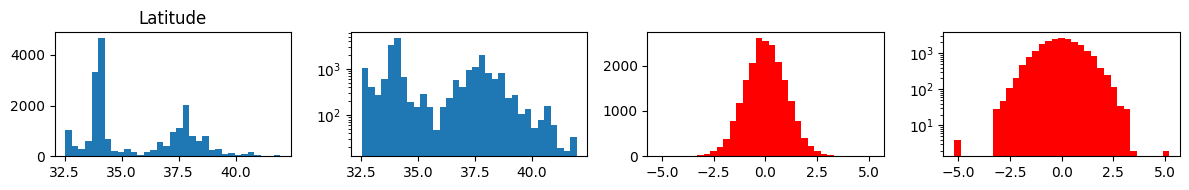

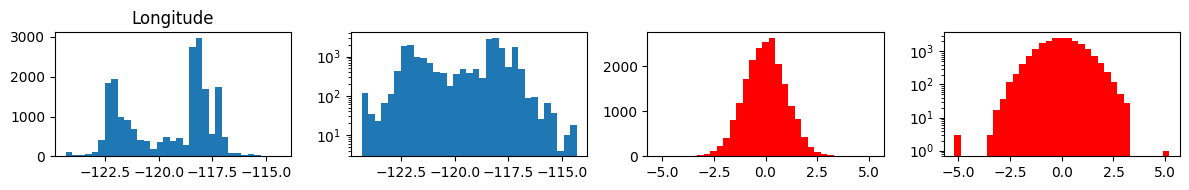

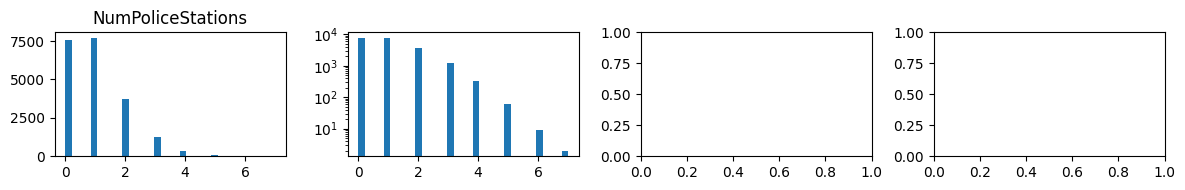

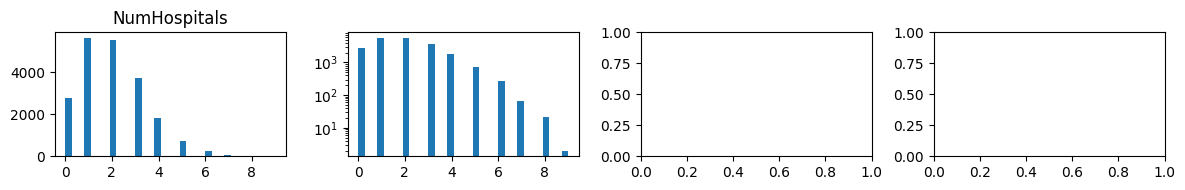

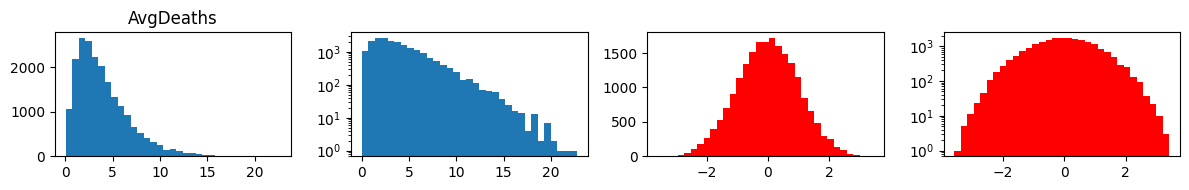

In [98]:
from sklearn.preprocessing import *

combined_func = {
    'MedInc': lambda x: np.log(x + 2),
    'AveRooms': lambda x: np.log(np.log(x + 2)),
    'AveBedrms': lambda x: x / (x * 2 + 1),
    'Population': lambda x:  np.log(x + 2),
    'AveOccup': lambda x:  np.log(np.log(np.log(x + 2)) + 1),
    'Latitude': lambda x: QuantileTransformer(output_distribution='normal').fit_transform(x.reshape(-1, 1)),
    'Longitude': lambda x: QuantileTransformer(output_distribution='normal').fit_transform(x.reshape(-1, 1)),
    'AvgDeaths': lambda x: PowerTransformer(method='box-cox').fit_transform(x.reshape(-1, 1)),
}

#  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
#       'Latitude', 'Longitude', 'NumPoliceStations', 'NumHospitals',
#       'AvgDeaths']

plot_df_cols(df, combined_func)

## Как подобрать функцию трансформации?

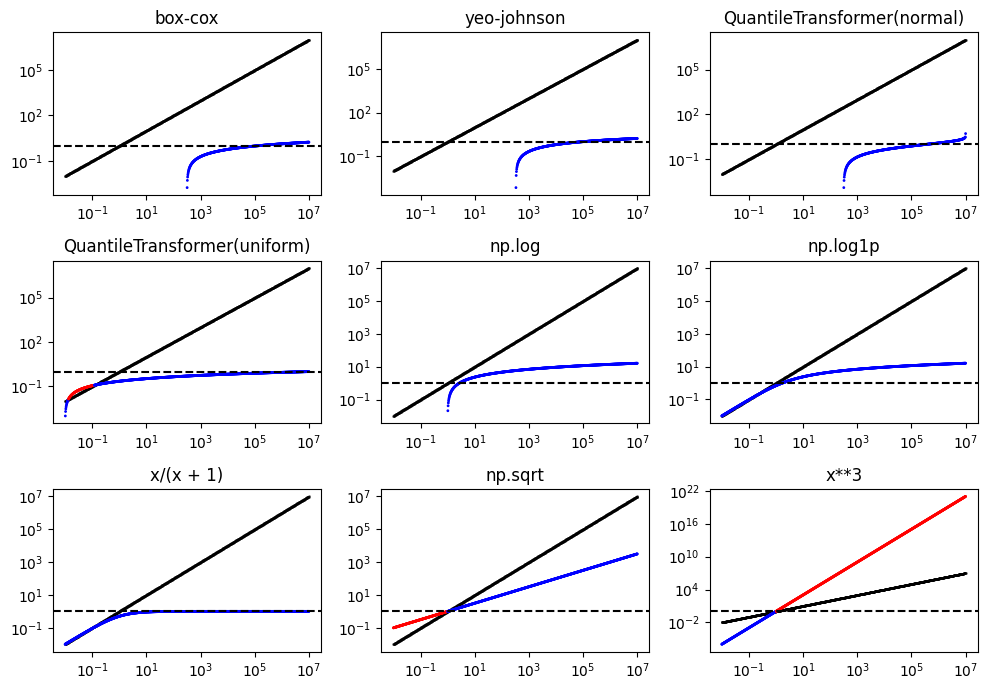

In [4]:
def plot_transform_func(func, line=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    line = line or np.logspace(-2, 7, num=1000)
    ax.scatter(line, line, s=1, color='black', alpha=0.5)
    ax.scatter(line, func(line), c=['red' if x else 'blue' for x in func(line) > line], s=1)
    ax.axhline(1, color='black', ls='--')
    ax.set_xscale('log')
    ax.set_yscale('log')

func_dict = {
    'box-cox': lambda x: PowerTransformer(method='box-cox', standardize=True).fit_transform(x.reshape(-1, 1))[:, 0],
    'yeo-johnson': lambda x: PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(x.reshape(-1, 1))[:, 0],
    'QuantileTransformer(normal)': lambda x: QuantileTransformer(output_distribution='normal').fit_transform(x.reshape(-1, 1))[:, 0],
    'QuantileTransformer(uniform)': lambda x: QuantileTransformer(output_distribution='uniform').fit_transform(x.reshape(-1, 1))[:, 0],
    'np.log': np.log,
    'np.log1p': np.log1p,
    'x/(x + 1)': lambda x: x / (x + 1),
    'np.sqrt': np.sqrt,
    'x**3': lambda x: x**3,
}

fig, ax = plt.subplots(3, 3, figsize=(10, 7))
for i, key in enumerate(func_dict):
    plot_transform_func(func_dict[key], ax=ax[i // 3][i % 3])
    ax[i // 3][i % 3].set_title(key)
fig.tight_layout()

In [5]:
# Идея -- график функция-больше/меньше

### Сранение влияния трансформаций на качество модели

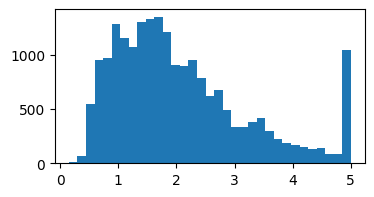

In [6]:
y = fetch_california_housing(as_frame=True).target
plt.hist(y, bins=33);
plt.gcf().set_size_inches(4, 2)

In [7]:
df.shape[0]

20640

#### 1. Линейная модель: Ridge

C:\Program Files\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.08631e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


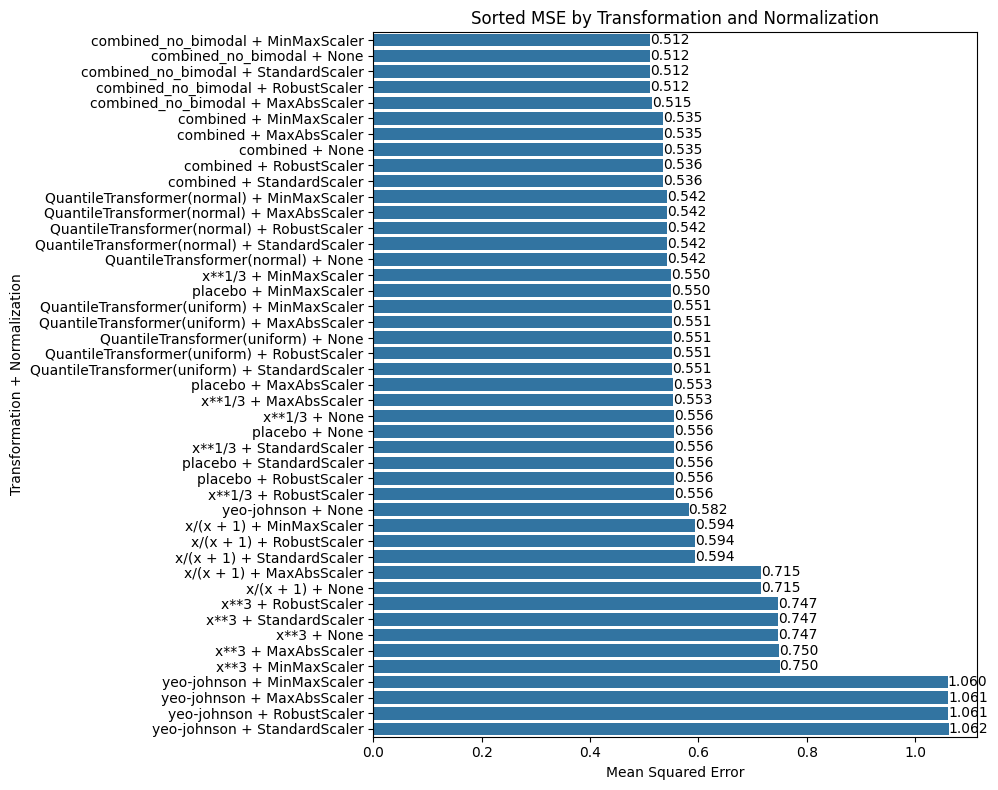

In [10]:
from sklearn.linear_model import Ridge
from utils import compare_transformations_and_normalizations, plot_sorted_mse_barplot

combined_transform_func_no_bimodal = combined_transform_func.copy()
del combined_transform_func_no_bimodal['Latitude']
del combined_transform_func_no_bimodal['Longitude']

func_dict = {
    'placebo': lambda x: x,
    # 'box-cox': lambda x: PowerTransformer(method='box-cox', standardize=True).fit_transform(x.reshape(-1, 1))[:, 0],
    'yeo-johnson': lambda x: PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(x.reshape(-1, 1))[:, 0],
    'QuantileTransformer(normal)': lambda x: QuantileTransformer(output_distribution='normal').fit_transform(x.reshape(-1, 1))[:, 0],
    'QuantileTransformer(uniform)': lambda x: QuantileTransformer(output_distribution='uniform').fit_transform(x.reshape(-1, 1))[:, 0],
    # 'np.log': np.log,
    # 'np.log1p': np.log1p,
    'x/(x + 1)': lambda x: x / (x + 1),
    'x**1/3': lambda x: x**1/3,
    'x**3': lambda x: x**3,
    'combined': combined_transform_func,
    'combined_no_bimodal': combined_transform_func_no_bimodal
    
}

scalers_dict = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

model = Ridge(tol=1e-5, alpha=0.1)
res = compare_transformations_and_normalizations(df, y, model=model, transformations=func_dict, normalizations=scalers_dict)
plot_sorted_mse_barplot(res)

#### 2. Линейная модель: SVM

C:\Program Files\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase

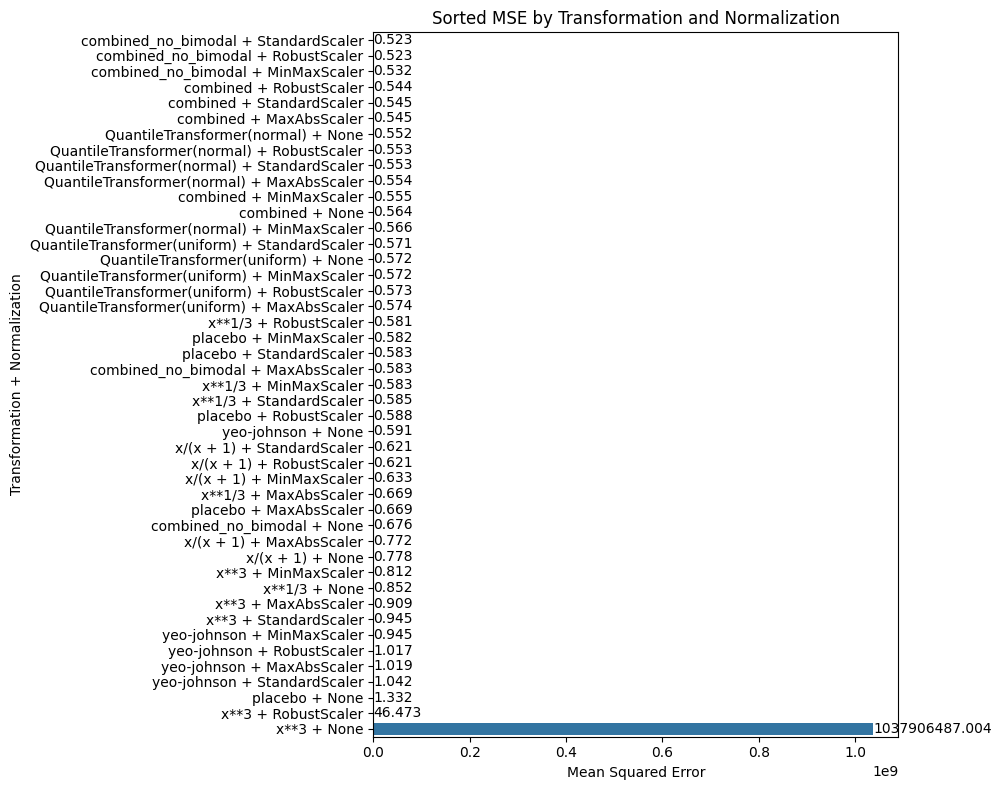

In [43]:
from sklearn.svm import LinearSVR

model = LinearSVR(tol=1e-4, C=0.1, max_iter=1000)
res = compare_transformations_and_normalizations(df, y, model=model, transformations=func_dict, normalizations=scalers_dict)
plot_sorted_mse_barplot(res)

#### 3. Метрический алгоритм

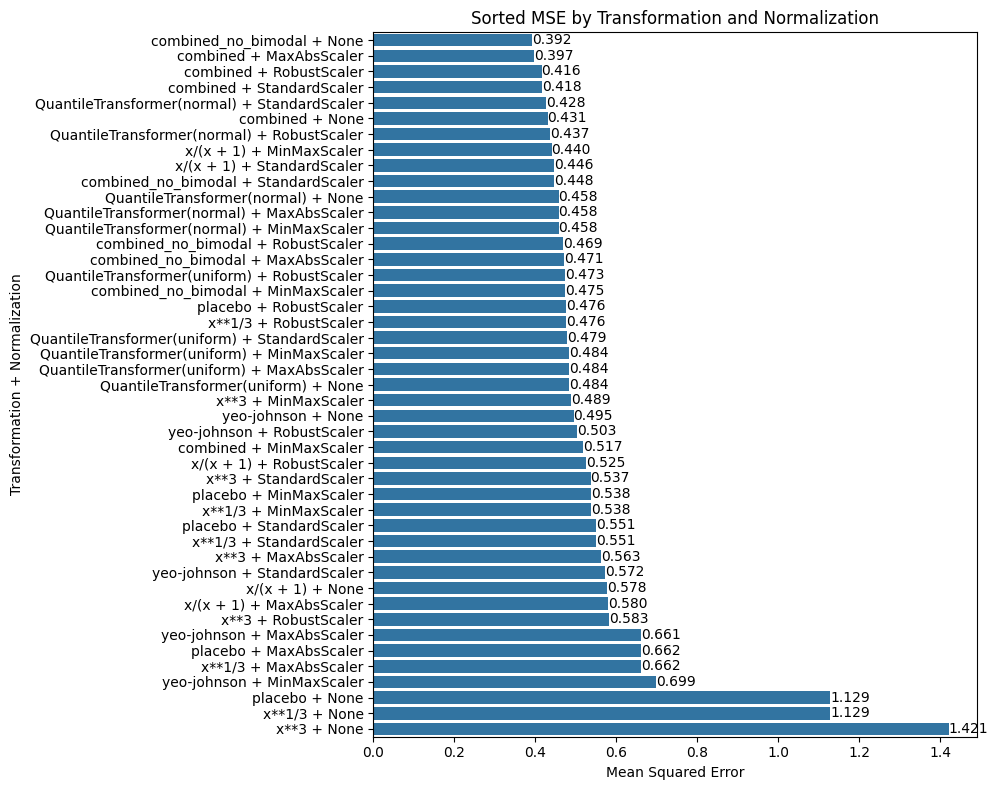

In [11]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=13)
res = compare_transformations_and_normalizations(df, y, model=model, transformations=func_dict, normalizations=scalers_dict)
plot_sorted_mse_barplot(res)

### Что делать с категориальными признаками? (и что за них считать?)
- `sklearn.preprocessing.LabelEncoder` (категория - число)
- `sklearn.preprocessing.TargetEncoder` (категория - число)
- `sklearn.preprocessing.OneHotEncoder` (категория - **эмбеддинг**)
- библиотечка [category_encoders](https://github.com/scikit-learn-contrib/category_encoders)

# Часть 2. Эмбеддинги как изначально однородные пространства

рассмотрим подходы без использования DL
### Эмбеддинги категорий
- `sklearn.preprocessing.OneHotEncoder`

### Эмбеддинги текстов/строк
- `sklearn.feature_extraction.text.CountVectorizer`
- `sklearn.feature_extraction.text.HashingVectorizer`
- `sklearn.feature_extraction.text.TfidfVectorizer`
- [GloVe](https://github.com/stanfordnlp/GloVe)
- [vectorizers](https://vectorizers.readthedocs.io/en/latest)

### Эмбеддинги последовательностей
- [vectorizers](https://vectorizers.readthedocs.io/en/latest) (можно мыслить тексты как последовательности слов)

### Эмбеддинги числового датафрейма (0_0)
- [rtdl_num embeddings от Yandex](https://github.com/yandex-research/rtdl-num-embeddings)

### Эмбеддинги картинок
out of scope

### Эмбеддинги графов
out of scope

### 2.1 Эмбеддинги текстов

In [12]:
from sklearn.datasets import fetch_20newsgroups

news, news_target = fetch_20newsgroups(return_X_y=True)
print(news[0].strip(), '\nTARGET:', news_target[0])
print('\n\n\n', news[1].strip(), '\nTARGET:', news_target[1])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ---- 
TARGET: 7



 From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: c

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), max_df=0.8, min_df=3, max_features=None, norm=None)
news_vectors = vectorizer.fit_transform(news)
news_vectors

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4558829 stored elements and shape (11314, 398248)>

In [14]:
type(news_vectors)

scipy.sparse._csr.csr_matrix

In [15]:
news_vectors[:10].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
%%time
from lightning.classification import SGDClassifier
from sklearn.metrics import balanced_accuracy_score


model = SGDClassifier(loss='log', penalty='l1', multiclass=True)
model.fit(news_vectors, news_target)
y_pred = model.predict(news_vectors)
print('y_pred[0]:', y_prob[0])
balanced_accuracy_score(news_target, y_prob, adjusted=True)

y_pred[0]: 3
CPU times: total: 5.73 s
Wall time: 6.04 s


0.45068653464046626

### 2.2 Эмбеддинги числового датафрейма

[статья](https://arxiv.org/abs/2203.05556)

In [106]:
import torch
from rtdl_num_embeddings import PiecewiseLinearEncoding, compute_bins
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(df, y, test_size=0.23, shuffle=True, random_state=911)

print('X_tr.shape:', X_tr.shape)
df_torch_tr = torch.tensor(X_tr.values)
df_torch_val = torch.tensor(X_val.values)

bins = compute_bins(df_torch_tr, n_bins=33)
mapper = PiecewiseLinearEncoding(bins=bins)
df_emb_tr = mapper.forward(df_torch_tr).numpy()
df_emb_val = mapper.forward(df_torch_val).numpy()

print('df_emb_tr.shape:', df_emb_tr.shape)
df_emb_tr

X_tr.shape: (15892, 11)
df_emb_tr.shape: (15892, 304)


array([[1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.01533042],
       ...,
       [1.        , 0.71553076, 0.        , ..., 0.23741148, 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [107]:
from sklearn.metrics import mean_squared_error

model = Ridge(tol=1e-5, alpha=0.01)
model.fit(df_emb_tr, y_tr)
y_pred = model.predict(df_emb_val)
score = mean_squared_error(y_val, y_pred)
score

0.3135445854514625

In [108]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(df_emb_tr)
X_val_scaled = scaler.transform(df_emb_val)
model = KNeighborsRegressor(n_neighbors=13)
model.fit(X_tr_scaled, y_tr)
y_pred = model.predict(X_val_scaled)
score = mean_squared_error(y_val, y_pred)
score

0.347417683820784